# Setting Source Folder

In [1]:
import os, sys

filedir = os.path.abspath(".")

currentdir = os.path.dirname(os.path.abspath(".")) # workaround to adding local modules

parentdir = os.path.dirname(os.path.abspath(""+currentdir))
print(f'CurrentDir: {currentdir}')
print(f'ParentDir: {parentdir}')

sys.path.insert(0, currentdir)

CurrentDir: /Users/renan.cristofalo/Documents/git/multimorbity_use
ParentDir: /Users/renan.cristofalo/Documents/git


# Importing Libraries

In [2]:

import pandas as pd
import numpy as np
import os.path as osp
from pathlib import Path

from src.ml.feature_selection import *
from src.ml.utils.preprocessors import select_preprocessor
from src.ml.utils.utils import get_ct_feature_names, write_joblib
from src.visualization.data_visualization import plot
from src.config import *


from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import set_config


import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = 200
set_config(display="diagram")

# Reading Data

In [3]:
SEED = 42

DATA_PATH = osp.join('..', 'data','processed','dataset_clean.csv')

DATA_DIR = osp.join('..', 'data','feature_selection','v2')
DATA_DIR_RAW = osp.join(DATA_DIR,'raw')



In [4]:

if not osp.exists(DATA_DIR_RAW):
    os.makedirs(DATA_DIR_RAW)
    
if not osp.exists(osp.join(DATA_DIR_RAW,'df_train.parquet')):
    pdf = pd.read_csv(DATA_PATH)
    
    X = pdf.drop(TARGET, axis = 1)
    y = pdf[TARGET]
    
    # Separating dataset onto train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)
    pd.DataFrame(data=pd.concat([X_train, y_train], axis = 1), columns=pdf.columns).to_parquet(osp.join(DATA_DIR_RAW,'df_train.parquet'))
    pd.DataFrame(data=pd.concat([X_test, y_test], axis = 1), columns=pdf.columns).to_parquet(osp.join(DATA_DIR_RAW,'df_test.parquet'))
else:
    # reading files
    df_train=pd.read_parquet(osp.join(DATA_DIR_RAW,'df_train.parquet'))
    df_test=pd.read_parquet(osp.join(DATA_DIR_RAW,'df_test.parquet'))
    
    X_train, X_test, y_train, y_test  = df_train.drop(TARGET, axis = 1), df_test.drop(TARGET, axis = 1), df_train[TARGET], df_test[TARGET]
    
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (2211, 381)
X_test shape: (948, 381)


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'pronto_atendimento'}, xlabel='pronto_atendimento', ylabel='count'>)

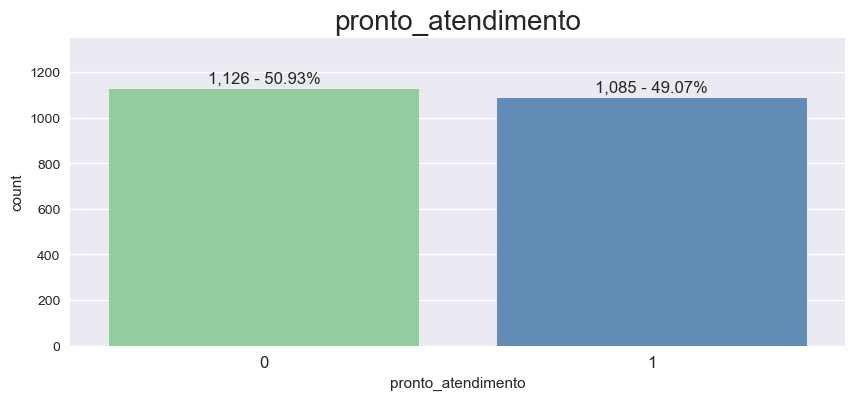

In [5]:
plot(
       'countplot'
     , df =y_train.to_frame()
     , columns= [TARGET]
     , ncols=1
     , plot_size = (10,4)
    #  , title=f"Target distribution - {'hospital_death'.title()} - ALL"
    , xlabel_rotation=0
    , rotation=0
)


# Data Preparation

## Identifying Unique

In [6]:
single_support, single_features, record_single_unique = identify_single_unique(X_train)

X_train_preprocessed = X_train[single_features]
X_test_preprocessed = X_test[single_features]

print('X_train.shape: ', X_train_preprocessed.shape)
print('X_test.shape: ', X_test_preprocessed.shape)

3 features with a single unique value.

X_train.shape:  (2211, 378)
X_test.shape:  (948, 378)


## Removing Missing

In [7]:
missing_support, missing_features, record_missing = identify_missing(X_train_preprocessed, missing_threshold=0.6)

X_train_preprocessed = X_train[missing_features]
X_test_preprocessed = X_test[missing_features]

print('X_train.shape: ', X_train_preprocessed.shape)
print('X_test.shape: ', X_test_preprocessed.shape)

58 features with greater than 0.60 missing values.

X_train.shape:  (2211, 320)
X_test.shape:  (948, 320)


## Defining preprocessor


In [8]:
preprocessor = select_preprocessor('TargetEncoding', X = X_train_preprocessed)
preprocessor

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('float',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['altura', 'peso', 'CW',
                                                   'pecas', 'abban', 'dcamt',
                                                   'sent', 'deit', 'tvs',
                                                   'nserv', 'sat', 'tsono',
                                                   'pfarm', 'cancer', 'peso1',
                                                   'altura1', 'bmi',
                                                   'rendasetor', 'rensetor10',
                                                   'urg', 'rensetor5',
                                                   '_Iren...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  ['setor', 'qplan',
                                                   'postoqual', 'pessoamt',
                                                   'pessoamta', 'pessoaem',
                                                   'pessoainf', 'pessoasp']),
                                                 ('bypass',
                                                  Pipeline(steps=[('Bypass',
                                                                   <src.ml.utils.preprocessors.BypassTransformer object at 0x12bbad8b0>)]),
                                                  [])])),
                ('sparse_to_dense', SparseToDenseTransformer())])

In [9]:
# Fit the preprocessor on the training data
preprocessor.fit(X_train_preprocessed, y=y_train)

# Get the column names after transformation
output_features = get_ct_feature_names(preprocessor[-2])

# Transform both the training and test data using the same preprocessor
# X_train_preprocessed = pd.DataFrame.sparse.from_spmatrix(data=preprocessor.transform(X_train), columns=output_features)
# X_test_preprocessed = pd.DataFrame.sparse.from_spmatrix(data=preprocessor.transform(X_test), columns=output_features)
X_train_preprocessed = pd.DataFrame(data=preprocessor.transform(X_train_preprocessed), columns=output_features)
X_test_preprocessed = pd.DataFrame(data=preprocessor.transform(X_test_preprocessed), columns=output_features)

print('X_train.shape: ', X_train_preprocessed.shape)
print('X_test.shape: ', X_test_preprocessed.shape)

X_train.shape:  (2211, 930)
X_test.shape:  (948, 930)


In [11]:
X_train_preprocessed.sample(10)

,altura,peso,cw,pecas,abban,dcamt,sent,deit,tvs,nserv,sat,tsono,pfarm,cancer,peso1,altura1,bmi,rendasetor,rensetor10,urg,rensetor5,_irensetor1_2,_irensetor1_3,_irensetor1_4,_irensetor1_5,_irensetor1_6,_irensetor1_7,_irensetor1_8,_irensetor1_9,_irensetor1_10,banheiroabep,empabep,carroabep,microabep,lavaloucabep,gelaabep,freeabep,lavaroupaabep,dvdabep,microondasabep,motoabep,secaabep,chefeabep,aguaabep,pavabep,abep,esperado,total,mor2,pw,pw1,pop,idade,icovid,depre1,depre2,depre3,depre4,depre5,depre6,depre7,depre8,depre9,depress,depre_algo,depresscat,phq_sum_b,depre_cut,ansi1,ansi2,ansi3,ansi4,ansi5,ansi6,ansi7,ansiss,ansi_algo,gad_sum_b,ansi_cut,popw,is,multi,m2,m3,hospit,cmdac1,cmddn1,dnali1,dmali1,mcom1,inseg,tcovid,asmbrq,multi_calc,nmor___-0,nmor___-1_apenas_o_proprio_respondente,nmor___-10_ou_mais,nmor___-2,nmor___-3,nmor___-4,...,fumo2___-nao_fuma_atualmente,alc2___-sim,bmi4cat___-eutrofia,bmi4cat___-magreza,bmi4cat___-obesidade,bmi4cat___-sobrepeso,obesidade___-sim,abepcat___-a,abepcat___-b1,abepcat___-b2,abepcat___-c1,abepcat___-c2,abepcat___-de,abepcat___-missing,esc4j___-ensino_fundamental_completo_medio_incom,esc4j___-ensino_medio_completo_superior_incomple,esc4j___-ensino_superior_completo_ou_mais,esc4j___-nunca_ensino_fundamental_incompleto,sexj___-male,cor2___-branca,cor2___-missing,cor2___-preta_parda_amar_indig,abep4___-a-b1,abep4___-c1,abep4___-c2,abep4___-de,abep4___-missing,j___-1,j___-2,j___-3,j___-4,j___-5,j___-6,j___-7,j___-homem_branco_rico_escolar,j___-missing,j___-mulher_preta-parda_pobre_baixa_esc,ds___-fim_de_semana,id4___-18-29,id4___-30-59,id4___-60-69,id4___-70,idibge___-18-29,idibge___-30-39,idibge___-40-49,idibge___-50-59,idibge___-60-69,idibge___-70-79,idibge___-80,estrato___-fem_18-29,estrato___-fem_30-39,estrato___-fem_40-49,estrato___-fem_50-59,estrato___-fem_60-69,estrato___-fem_70-79,estrato___-fem_80,estrato___-masc_18-29,estrato___-masc_30-39,estrato___-masc_40-49,estrato___-masc_50-59,estrato___-masc_60-69,estrato___-masc_70-79,estrato___-masc_80,gad_sintomas___-leves,gad_sintomas___-moderados,gad_sintomas___-sem_sintomas,gad_sintomas___-severos,gad_sintomas___-missing,gad_severity___-mild,gad_severity___-minimal,gad_severity___-moderate,gad_severity___-severe,gad_severity___-missing,gad_severo___-missing,gad_severo___-nao,gad_severo___-sim,phq_severity___-mild,phq_severity___-minimal,phq_severity___-moderate,phq_severity___-moderately_severe,phq_severity___-severe,phq_severity___-missing,id2___-idoso,pros___-nao,pros___-sim,pros___-missing,testecovid___-algum_teste_laboratorial_nao_tem_certeza_de_qual,testecovid___-diagnostico_medico_sem_a_realizacao_de_teste_laboratorial,testecovid___-ign,testecovid___-nao,testecovid___-sim_teste_rt-qpcr_virus,testecovid___-sim_teste_rapido_anticorpos,setor,qplan,postoqual,pessoamt,pessoamta,pessoaem,pessoainf,pessoasp
1038,-0.25,-1.11,0.36,0.32,-0.22,-0.04,-0.37,-0.32,0.20,-0.20,1.07,0.08,-0.62,-0.21,-1.11,-0.25,-1.10,-0.84,-1.63,-0.65,-1.49,-0.30,-0.32,-0.33,-0.37,-0.31,-0.36,-0.35,-0.33,-0.33,-0.63,-0.14,0.64,-0.93,-0.19,-0.13,-0.82,0.31,-0.39,-1.71,1.73,-0.42,-0.38,0.07,-1.02,-0.79,0.43,0.32,1.00,-0.12,-0.17,0.33,-0.43,-0.45,-0.46,-0.46,-0.51,-0.52,-0.40,-0.33,-0.41,-0.27,-0.25,-0.46,-0.35,-0.35,-0.87,-0.49,-0.60,-0.42,-0.62,-0.48,-0.35,-0.49,-0.36,-0.55,-0.55,-0.75,-0.46,-0.38,-0.31,-0.96,-0.87,-0.59,-0.23,-0.53,-0.33,1.89,-0.31,-0.32,1.60,-0.88,-0.32,-0.95,0.00,0.00,0.00,0.00,0.00,1.00,...,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.20,0.48,0.25,0.50,0.50,0.49,0.52,0.53
1874,-0.68,-1.11,0.36,-0.11,-0.22,0.00,-1.20,-0.62,-0.70,-0.20,0.46,

# FEATURE SELECTION

## Colinear Removal

In [12]:
collinear_support, collinear_features, record_collinear = collinear_removal(X_train_preprocessed, y_train, 0.8)

X_train_preprocessed = X_train_preprocessed[collinear_features]
X_test_preprocessed = X_test_preprocessed[collinear_features]

print('X_train.shape: ', X_train_preprocessed.shape)
print('X_test.shape: ', X_test_preprocessed.shape)

284 features with a correlation magnitude greater than 0.80.

X_train.shape:  (2211, 646)
X_test.shape:  (948, 646)


In [13]:
record_collinear.head(10)

,drop_feature,corr_feature,corr_value
0,atd___-nao,jnprecisou___-missing,-1.00
1,jnprecisou___-nao,jnprecisou___-missing,-0.83
2,jnprecisou___-nao,atd___-nao,0.82
3,jnprecisou___-nao,jnbuscou___-nao,0.84
4,multi,multi_calc,1.00
5,jnbuscou___-sim,jnbuscou___-nao,-1.00
6,jnbuscou___-sim,jnprecisou___-nao,-0.84
7,jnconseguiu___-missing,jnbuscou___-nao,1.00
8,jnconseguiu___-missing,jnprecisou___-nao,0.84
9,jnconseguiu___-missing,jnbuscou___-sim,-1.00


In [14]:
X_train_preprocessed.sample(10)

,altura,cw,pecas,dcamt,sent,deit,tvs,nserv,sat,tsono,pfarm,bmi,rendasetor,rensetor10,urg,_irensetor1_2,_irensetor1_3,_irensetor1_4,_irensetor1_5,_irensetor1_6,_irensetor1_7,_irensetor1_8,_irensetor1_9,banheiroabep,carroabep,microabep,gelaabep,lavaroupaabep,microondasabep,motoabep,chefeabep,abep,esperado,total,mor2,pw,pw1,pop,depre3,depre4,depre5,depre6,depre7,depre8,depre9,depre_cut,ansi2,ansi3,ansi4,ansi5,ansi6,ansi7,ansiss,popw,m2,multi_calc,nmor___-0,nmor___-1_apenas_o_proprio_respondente,nmor___-10_ou_mais,nmor___-2,nmor___-3,nmor___-4,nmor___-5,nmor___-6,nmor___-7,nmor___-8,nmor___-9,genero___-homem_cisgenero_1,genero___-homem_trans_ou_transgenero_2,genero___-mulher_trans_transgenero_ou_travesti_2,genero___-prefiro_nao_me_classificar,cor___-amarela_orientais,cor___-ign,cor___-indigena,cor___-outra,ler___-nao,ler___-sim,ler___-so_assina,escol___-1deg_serie_do_2o_grau,escol___-1o_serie_do_1o_grau,escol___-2o_serie_do_1o_grau,escol___-2o_serie_do_2o_grau,escol___-3o_serie_do_1o_grau,escol___-3o_serie_do_2o_grau_antigo_colegial_classico_cientifico_normal,escol___-4o_serie_do_1o_grau_antigo_primario_ou_grupo,escol___-5o_serie_do_1o_grau,escol___-6o_serie_do_1o_grau,escol___-7o_serie_do_1o_grau,escol___-8o_serie_do_1o_grau_antigo_ginasio,escol___-doutorado,escol___-especializacao_residencia_medica,escol___-mestrado,escol___-nunca_estudou,escol___-superior_incompleto,escol___-supletivo_madureza_eja,sit___-aposentado_a,sit___-desempregado_a,sit___-do_lar,sit___-estudando,sit___-ign,...,cama___-sim_sempre,cama___-sim_as_vezes,lugares___-sim_sempre,lugares___-sim_as_vezes,banheiro___-sim_sempre,banheiro___-sim_as_vezes,alimentar___-sim_sempre,alimentar___-sim_as_vezes,cappd___-ign,cappd___-melhor,cappd___-mesma_coisa,cappd___-pior,mcj___-ign,mcj___-sim,dge___-ign,dge___-sim,dsp___-ign,dsp___-sim,vlc___-sim,sozi___-nao,serv___-sim,conj3___-married,conj3___-single_divorced,conj3___-missing,cor4___-brown,cor4___-other,estudo4cat___-ensino_superior_completo_ou_mais,fumo2___-missing,bmi4cat___-eutrofia,bmi4cat___-magreza,bmi4cat___-sobrepeso,obesidade___-sim,abepcat___-a,abepcat___-b1,abepcat___-c2,esc4j___-ensino_fundamental_completo_medio_incom,esc4j___-nunca_ensino_fundamental_incompleto,cor2___-preta_parda_amar_indig,abep4___-a-b1,abep4___-c1,abep4___-de,j___-1,j___-2,j___-3,j___-4,j___-5,j___-6,j___-7,j___-homem_branco_rico_escolar,j___-missing,j___-mulher_preta-parda_pobre_baixa_esc,ds___-fim_de_semana,id4___-18-29,id4___-30-59,id4___-60-69,id4___-70,idibge___-30-39,idibge___-40-49,idibge___-50-59,idibge___-80,estrato___-fem_18-29,estrato___-fem_40-49,estrato___-fem_50-59,estrato___-fem_60-69,estrato___-fem_80,estrato___-masc_18-29,estrato___-masc_30-39,estrato___-masc_40-49,estrato___-masc_50-59,estrato___-masc_60-69,estrato___-masc_70-79,estrato___-masc_80,gad_sintomas___-leves,gad_sintomas___-moderados,gad_sintomas___-severos,gad_severity___-mild,gad_severity___-moderate,gad_severity___-severe,phq_severity___-mild,phq_severity___-minimal,phq_severity___-moderate,phq_severity___-moderately_severe,phq_severity___-severe,id2___-idoso,pros___-sim,pros___-missing,testecovid___-algum_teste_laboratorial_nao_tem_certeza_de_qual,testecovid___-diagnostico_medico_sem_a_realizacao_de_teste_laboratorial,testecovid___-ign,testecovid___-nao,testecovid___-sim_teste_rt-qpcr_virus,testecovid___-sim_teste_rapido_anticorpos,setor,qplan,postoqual,pessoamt,pessoamta,pessoaem,pessoainf,pessoasp
1448,-0.03,0.36,-0.55,0.00,0.63,-0.62,1.54,-0.20,-1.94,-0.21,0.31,-0.02,-0.54,-0.92,-0.65,-0.30,3.09,-0.33,-0.37,-0.31,-0.36,-0.35,-0.33,0.88,0.64,1.34,-0.13,0.31,0.53,-0.44,-0.82,0.79,-0.74,-0.78,-0.42,-0.35,-0.08,-1.01,-0.51,-0.52,-0.40,-0.33,-0.41,-0.27,-0.25,-0.49,-0.42,-0.62,-0.48,-0.35,-0.49,-0.36,-0.55,-0.40,1.16,0.19,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,

## Voting Process

100%|██████████| 50/50 [00:15<00:00,  3.23it/s]

Optimum number of features: 16
Score (roc_auc) with 16 features: 72.445494
[2023_09_21-13_52_59] TE: 16 seconds


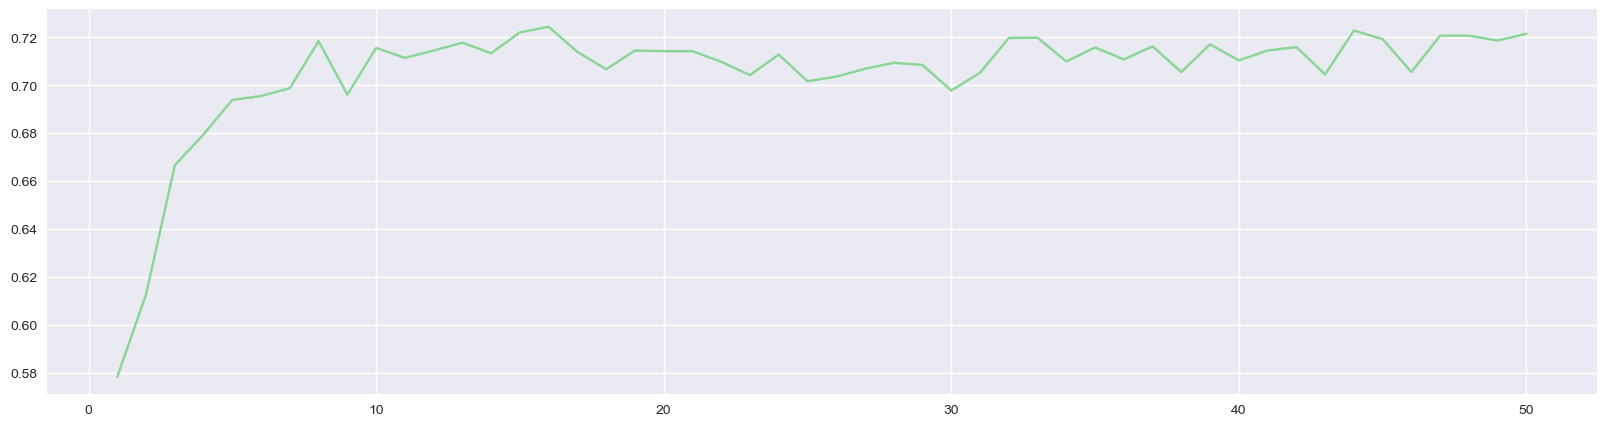

In [15]:
k_best_support, k_best_features=loop_k_features(
                                            X=X_train_preprocessed
                                            , y=y_train
                                            , model=LGBMClassifier(random_state=SEED)
                                            , method='KBest'
                                            , metric = 'roc_auc'
                                            , max_features = 50
                                        )


100%|██████████| 30/30 [2:04:37<00:00, 249.26s/it]  

Optimum number of features: 20
Score (roc_auc) with 20 features: 71.457122
[2023_09_21-15_57_37] TE: 2 hours 4 minutes e 38 seconds


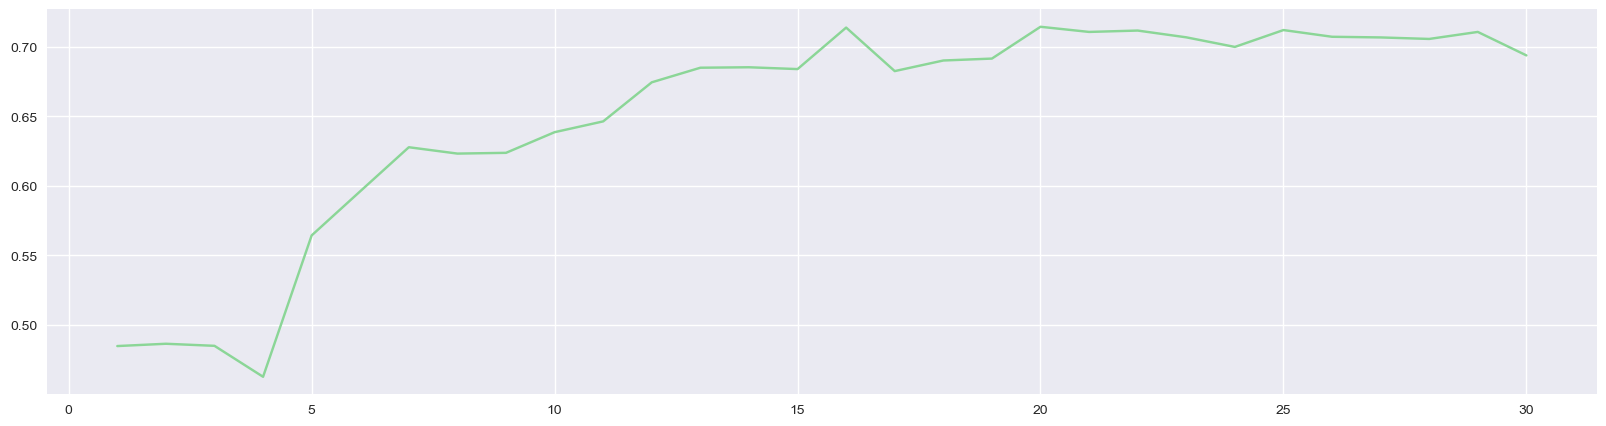

In [16]:
rfe_support, rfe_features=loop_k_features(
                                            X=X_train_preprocessed
                                            , y=y_train
                                            , model=LGBMClassifier(random_state=SEED)
                                            , method='RFE'
                                            , metric = 'roc_auc'
                                            , max_features = 30
                                        )


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]

Optimum number of features: 40
Score (roc_auc) with 40 features: 73.001453
[2023_09_21-15_58_11] TE: 34 seconds


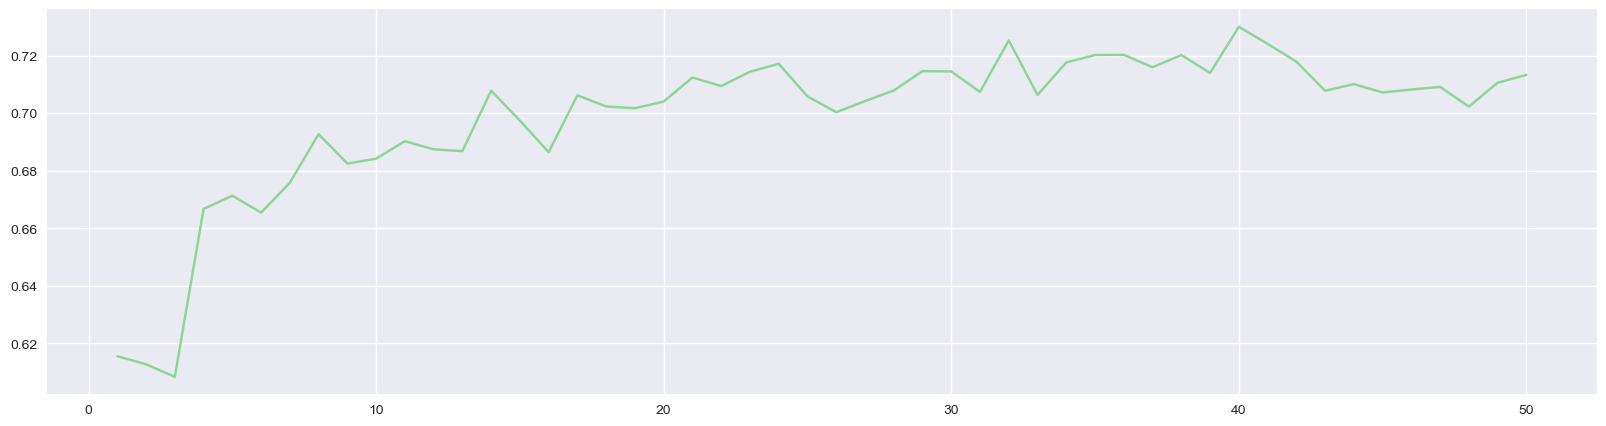

In [17]:
FM_support, FM_features=loop_k_features(
                                        X=X_train_preprocessed
                                        , y=y_train
                                        , model=LGBMClassifier(random_state=SEED)
                                        , method='FromModel'
                                        , metric = 'roc_auc'
                                        , max_features = 50
                                    )

Best alpha using built-in LassoCV: 0.005596
Best score using built-in LassoCV: 0.228536
Lasso picked 52 variables and eliminated the other 594 variables


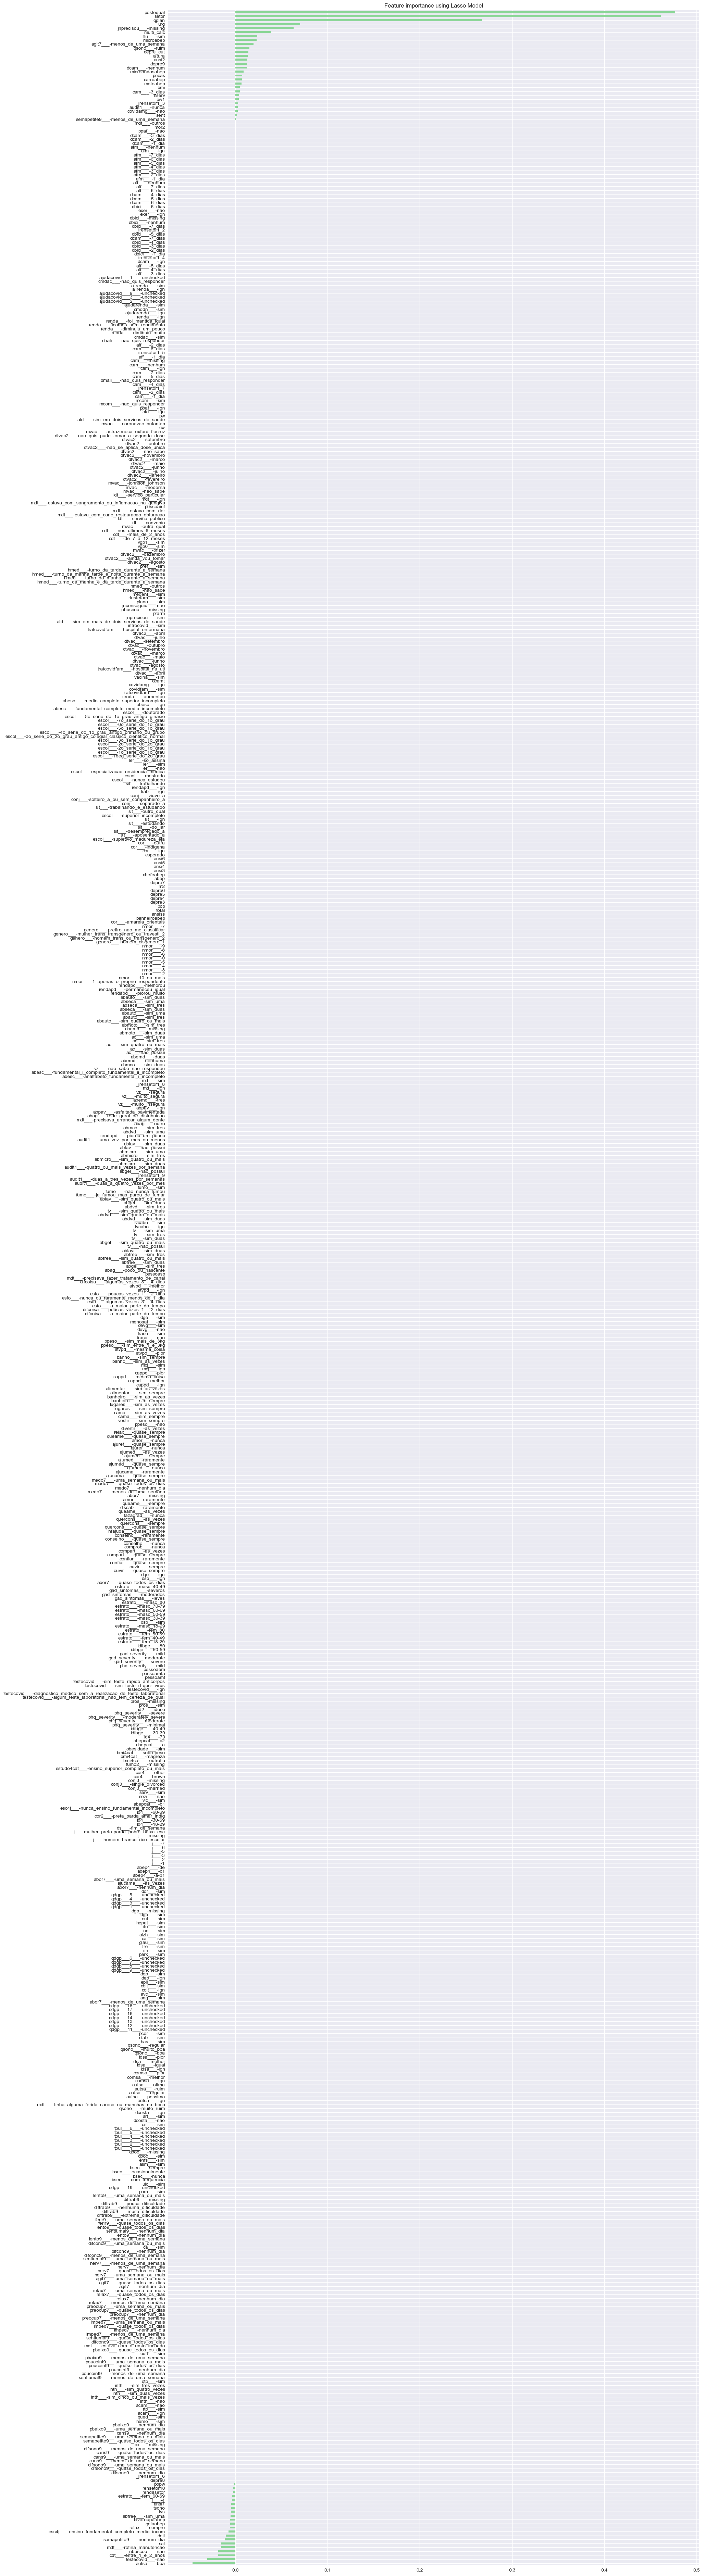

In [18]:
Lasso_support, Lasso_features = Lasso_selection(X=X_train_preprocessed, y=y_train,eps=0.05, n_alphas=100,cv=10)

In [19]:
borutashap_support, borutashap_features = BorutaShap_selection(
      X=X_train_preprocessed
    , y=y_train
    , model=LGBMClassifier(n_estimators = 100, random_state=SEED)
    , kwargs={"n_trials": 100, "random_state": 0, "normalize": False, "verbose": False}
)

Starting BorutaShap



  0%|          | 0/100 [00:00<?, ?it/s]

0 tentative features are now accepted: []
0 tentative features are now rejected: []
BorutaShap picked 6 variables and eliminated the other 640 variables


In [20]:
# original_features = X_train.columns

# selected_features_original = list(set([
#             input_col
#             for input_col in original_features
#             if any(
#                 input_col == selected_col.split("___-")[0]
#                 for selected_col in borutashap_features
#             )
#         ]))

# X_train_selected=X_train[selected_features_original]
# X_test_selected=X_test[selected_features_original]

# if not osp.exists(osp.join(osp.join('..', 'data', 'feature_selection', 'boruta'))):
#     os.mkdir(osp.join(osp.join('..', 'data', 'feature_selection', 'boruta')))
    
# print('X_train.shape: ', X_train_selected.shape)
# print('X_test.shape: ', X_test_selected.shape)

# pd.concat([X_train_selected,y_train], axis=1).to_parquet(osp.join('..', 'data', 'feature_selection', 'boruta', 'df_train.parquet'))
# pd.concat([X_test_selected,y_test], axis=1).to_parquet(osp.join('..', 'data', 'feature_selection', 'boruta', 'df_test.parquet'))

In [33]:
if not osp.exists(osp.join(osp.join(DATA_DIR, 'fs'))):
    os.mkdir(osp.join(osp.join(DATA_DIR, 'fs')))


voting_dict={'Features': X_train_preprocessed.columns
             ,'KBest':k_best_support
             ,'RFE': rfe_support
             ,'FM':FM_support
             ,'Lasso':Lasso_support
             ,'BorutaShap':borutashap_support
             }

selected_features, feature_selection_df=voting(voting_dict,threshold=3)

feature_selection_df.to_parquet(osp.join(DATA_DIR, 'fs','feature_selection_df.parquet'))
feature_selection_df

,Features,KBest,RFE,FM,Lasso,BorutaShap,Total
1,setor,True,True,True,True,True,5
2,qplan,True,True,True,True,True,5
3,postoqual,True,True,True,True,True,5
4,nserv,False,True,True,True,True,4
5,tvs,False,True,True,True,False,3
6,testecovid___-nao,True,False,True,True,False,3
7,sent,False,True,True,True,False,3
8,rendasetor,False,True,True,True,False,3
9,popw,False,True,True,True,False,3
10,pessoasp,False,True,True,False,True,3


In [34]:
selected_features = feature_selection_df['Features'].to_list()

In [35]:
original_features = X_train.columns


def get_selected_features_original(original_features, selected_features):
    selected_features_original = list(set([
                input_col
                for input_col in original_features
                if any(
                    input_col == selected_col.split("___-")[0]
                    for selected_col in selected_features
                )
            ]))
    return selected_features_original

selected_features_original =get_selected_features_original(original_features, selected_features)

In [36]:
selected_features_original

['nserv',
 'autsa',
 'postoqual',
 'pessoasp',
 'jnprecisou',
 'qplan',
 'pessoaem',
 'popw',
 'setor',
 'pessoainf',
 'tvs',
 'bmi',
 'rendasetor',
 'multi_calc',
 'altura',
 'sent',
 'testecovid',
 'jnbuscou']

In [37]:
X_train_selected=X_train[selected_features_original]
X_test_selected=X_test[selected_features_original]

print('X_train.shape: ', X_train_selected.shape)
print('X_test.shape: ', X_test_selected.shape)

X_train.shape:  (2211, 18)
X_test.shape:  (948, 18)


In [38]:
X_train_selected.sample(10)

,nserv,autsa,postoqual,pessoasp,jnprecisou,qplan,pessoaem,popw,setor,pessoainf,tvs,bmi,rendasetor,multi_calc,altura,sent,testecovid,jnbuscou
1578,0.00,Ótima,posto caique,Sobrinho,Não,master desconto,Mãe,29.95,431440705130067 - TRÊS VENDAS,Sobrinho,120.00,34.48,"1,306.00",1,157.00,480.00,"Sim, teste rápido (anticorpos)",Não
2904,0.00,Regular,Ubs união de bairros,Filho,Não,NaN,Filho,28.79,431440705130068 - TRÊS VENDAS,Filho,180.00,31.11,"1,200.00",3,150.00,180.00,Não,Não
2066,0.00,Boa,Ubs Virgilio Costa,Filha,NaN,NaN,Outro,49.96,"431440705150065, FRAGATA",Outro,120.00,22.23,"1,446.00",0,167.00,120.00,"Sim, teste RT-qPCR (vírus)",Sim
588,1.00,Boa,NaN,Esposo,Não,NaN,Esposo,25.57,431440705150010 - FRAGATA,Esposo,60.00,27.34,"1,421.00",5,160.00,60.00,Não,Não
1440,0.00,Regular,Ubs navegantes,Filha,Sim,NaN,Filha,35.58,431440705200027 - SÃO GONÇALO,Filha,120.00,33.79,966.00,1,165.00,360.00,Não,Não
659,0.00,Boa,NaN,Esposo,Não,NaN,Mãe,49.88,431440705150016 - FRAGATA,Mãe,240.00,25.16,"1,068.00",0,168.00,500.00,Não,Não
2625,0.00,Boa,NaN,Esposa,Não,NaN,Amigo,63.65,431440705150006 - FRAGATA,Amigo,180.00,19.47,"1,604.00",1,165.00,60.00,Não,Não
1389,0.00,Regular,Ubs navegantes,Esposo,Não,NaN,Esposo,25.57,431440705200027 - SÃO GONÇALO,Esposo,120.00,24.56,966.00,2,155.00,360.00,Não,Sim
2340,0.00,Boa,Ubs guabiroba,Filho,Sim,NaN,Filho,28.79,"431440705150015, FRAGATA",Filho,180.00,31.91,946.00,1,167.00,240.00,Não,Sim
241,0.00,Boa,Ubs areal,Amiga,NaN,Unimed,Mãe,49.88,431440705190001 - LARANJAL/Z3,Mãe,0.00,25.40,"6,197.00",0,166.00,360.00,"Sim, teste RT-qPCR (vírus)",Sim


In [39]:
if not osp.exists(osp.join(osp.join(DATA_DIR, 'fs'))):
    os.mkdir(osp.join(osp.join(DATA_DIR, 'fs')))

pd.concat([X_train_selected,y_train], axis=1).to_parquet(osp.join(DATA_DIR, 'fs','df_train.parquet'))
pd.concat([X_test_selected,y_test], axis=1).to_parquet(osp.join(DATA_DIR, 'fs','df_test.parquet'))

In [40]:
selected_features = feature_selection_df[feature_selection_df['BorutaShap']]['Features'].to_list()

In [41]:
if not osp.exists(osp.join(osp.join(DATA_DIR, 'boruta'))):
    os.mkdir(osp.join(osp.join(DATA_DIR, 'boruta')))
    
selected_features = feature_selection_df[feature_selection_df['BorutaShap']]['Features'].to_list()
selected_features_original =get_selected_features_original(original_features, selected_features)

pd.concat([X_train[selected_features_original],y_train], axis=1).to_parquet(osp.join(DATA_DIR, 'boruta','df_train.parquet'))
pd.concat([X_test[selected_features_original],y_test], axis=1).to_parquet(osp.join(DATA_DIR, 'boruta','df_test.parquet'))

In [42]:
if not osp.exists(osp.join(osp.join(DATA_DIR, 'FM'))):
    os.mkdir(osp.join(osp.join(DATA_DIR, 'FM')))
    
selected_features = feature_selection_df[feature_selection_df['FM']]['Features'].to_list()
selected_features_original =get_selected_features_original(original_features, selected_features)

pd.concat([X_train[selected_features_original],y_train], axis=1).to_parquet(osp.join(DATA_DIR, 'FM','df_train.parquet'))
pd.concat([X_test[selected_features_original],y_test], axis=1).to_parquet(osp.join(DATA_DIR, 'FM','df_test.parquet'))

In [43]:
if not osp.exists(osp.join(osp.join(DATA_DIR, 'FM_MUST'))):
    os.mkdir(osp.join(osp.join(DATA_DIR, 'FM_MUST')))
    
selected_features = feature_selection_df[feature_selection_df['FM']]['Features'].to_list() + must_have_features
selected_features_original =get_selected_features_original(original_features, selected_features)

pd.concat([X_train[selected_features_original],y_train], axis=1).to_parquet(osp.join(DATA_DIR, 'FM_MUST','df_train.parquet'))
pd.concat([X_test[selected_features_original],y_test], axis=1).to_parquet(osp.join(DATA_DIR, 'FM_MUST','df_test.parquet'))

In [44]:
if not osp.exists(osp.join(osp.join(DATA_DIR, 'fs_must'))):
    os.mkdir(osp.join(osp.join(DATA_DIR, 'fs_must')))
    
selected_features = feature_selection_df['Features'].to_list() + must_have_features
selected_features_original =get_selected_features_original(original_features, selected_features)

pd.concat([X_train[selected_features_original],y_train], axis=1).to_parquet(osp.join(DATA_DIR, 'fs_must','df_train.parquet'))
pd.concat([X_test[selected_features_original],y_test], axis=1).to_parquet(osp.join(DATA_DIR, 'fs_must','df_test.parquet'))